## Kalman filter

In [13]:
import numpy as np

# convenience shortcuts
def d2(a):
  return np.atleast_2d(a)

def d1(a):
  return np.atleast_1d(a)

def ext_kf(u,P,F,Q,d=None,H=None,R=None):
  """
  One step of the extended Kalman filter. 
  If there is no data, only advance in time.
  :param u:   the state vector, shape n
  :param P:   the state covariance, shape (n,n)
  :param Q:   the process model noise covariance, shape (n,n)
  :param F:   the model function, maps vector u to vector F(u) and Jacobian J(u)
  :param d:   data vector, shape (m)
  :param H:   observation matrix, shape (m,n)
  :param R:   data error covariance, shape (n,n)
  :return ua: the analysis state vector, shape (n)
  :return Pa: the analysis covariance matrix, shape (n,n)
  """
  # forecast
  uf, J  = F(u)          # advance the model state in time and get the Jacobian
  Pf  = d2(J.T @ P) @ J + Q  # advance the state covariance Pf = J' * P * J + Q
  # analysis
  if d is None or not d.size :  # no data, no analysis
    return uf, Pf
  # K = P H' * inverse(H P H' + R) = (inverse(H P H' + R)*(H P))' 
  HP  = d2(H @ P)            # precompute a part used twice  
  K   = d2(np.linalg.solve( d2(HP @ H.T) + R, HP)).T  # Kalman gain
  print('H',H)
  print('K',K)
  res = d1(H @ d1(uf) - d)
  ua = uf - K @ res # analysis mean
  Pa = Pf - K @ d2(H @ P)        # analysis covariance
  return ua, Pa


##  A basic exponential decay model

The model is defined by solving the differential equation on interval $\left[
t_{0},t_{1}\right]  $,
$$
\frac{dm}{dt}=\frac{E-m(t)}{T},\quad m(t_{0})=m_{0}.
$$
where the initial fuel moisture content $m_{0}=m\left(  t_{0}\right)  $ is the
input, and $m_{1}=m(t_{1})$ is the output. The parameters of the model are
fuel moisture equilibrium $E$, assumed constant over the interval $\left[
t_{0},t_{1}\right]  $, the characteristic decay time $T$, and the length of
the interval, $t_{1}-t_{0}$. 

We can build the general model by calling this simple model with different
equilibria and time constants (drying, wetting, rain).

Since $E$ is constant in time, the solution can be found
analytically,
$$
m\left(  t\right)  =E+\left(  m_{0}-E\right)  e^{-t/T}%
$$
For convenience, we use $T_{1}=1/T$ instead of $T$, and the model becomes
$$
m_{1}=E+\left(  m_{0}-E\right)  e^{-\left(  t_{1}-t_{0}\right)  T_{1}}%
$$
In the extended Kalman filter, we will need the partial derivatives of $m_{1}$
with respect to the input and the parameters. Compute
$$
\frac{dm_{1}}{d_{m0}}=e^{-\left(  t_{1}-t_{0}\right)  T_{1}}
$$
$$
\frac{dm_{1}}{dE}=1-e^{-\left(  t_{1}-t_{0}\right)  T_{1}}
$$
$$
\frac{dm_{1}}{dT_{1}}=-\left(  m_{0}-E\right)  \left(  t_{1}-t_{0}\right)
e^{-\left(  t_{1}-t_{0}\right)  T_{1}}
$$
At the moment, we need only ${dm_{1}}/{dm_{0}}$ but we put in the code all partials for possible use infuture.


In [3]:
import numpy as np
def model_decay(m0,E,partials=0,T1=0.1,tlen=1):
  exp_t = np.exp(-tlen*T1)                  # compute this subexpression only once
  m1 = E + (m0 - E)*exp_t                   # the solution at end
  if partials==0:
    return m1
  dm1_dm0 = exp_t
  if partials==1:
    return m1, np.array([dm1_dm0])          # return value and Jacobian
  dm1_dE = 1 - exp_t                        # partial derivative dm1 / dE
  dm1_dT1 = -(m0 - E)*tlen*exp_t            # partial derivative dm1 / dT1
  return m1, dm1_dm0, dm1_dE, dm1_dT1       # return value and all partial derivatives wrt m1 and parameters
  

## Kalman filter demonstration

### Create synthetic data

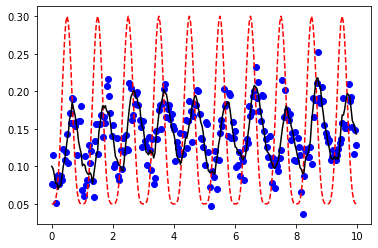

In [4]:
import numpy as np, random
days = 10       
hours = days*24
day = np.array(range(hours))/24.
# artificial equilibrium data
E = np.power(np.sin(np.pi*day),4) # diurnal curve
E = 0.05+0.25*E # scale 
# FMC free run
m_f = np.zeros(hours)
m_f[0] = 0.1         # initial FMC
for t in range(hours-1):
  m_f[t+1] = max(0.,model_decay(m_f[t],E[t])  + random.gauss(0,0.005) )
data = m_f + np.random.normal(loc=0,scale=0.02,size=hours)    

%matplotlib inline
import matplotlib.pyplot as plt 
plt.plot(day,E,linestyle='--',c='r',label='Equilibrium')
plt.plot(day,m_f,linestyle='-',c='k',label='10-h fuel truth')
plt.scatter(day,data,c='b',label='10-h fuel data')
 

### Run Kalman filter

In [14]:
import numpy as np

m = np.zeros(hours)
m[0]=0.1             # background state                  
P = np.array([0.03]) # background state variance
Q = np.array([0.02]) # process noise variance
H = np.array([1.])   # all observed
R = np.array([0.02]) # data variance

DeltaE = 0.          # 
for t in range(hours - 1):
  # use lambda construction to pass additional arguments to the model 
  m[t+1],P = ext_kf(m[t],P,lambda u: model_decay(u,E[t]+DeltaE,partials=1),Q,
                    d=data[t],H=H,R=R)

H [1.]
K [[0.6]]
H [1.]
K [[0.57046447]]
H [1.]
K [[0.57076414]]
H [1.]
K [[0.57076507]]
H [1.]
K [[0.57076507]]
H [1.]
K [[0.57076507]]
H [1.]
K [[0.57076507]]
H [1.]
K [[0.57076507]]
H [1.]
K [[0.57076507]]
H [1.]
K [[0.57076507]]
H [1.]
K [[0.57076507]]
H [1.]
K [[0.57076507]]
H [1.]
K [[0.57076507]]
H [1.]
K [[0.57076507]]
H [1.]
K [[0.57076507]]
H [1.]
K [[0.57076507]]
H [1.]
K [[0.57076507]]
H [1.]
K [[0.57076507]]
H [1.]
K [[0.57076507]]
H [1.]
K [[0.57076507]]
H [1.]
K [[0.57076507]]
H [1.]
K [[0.57076507]]
H [1.]
K [[0.57076507]]
H [1.]
K [[0.57076507]]
H [1.]
K [[0.57076507]]
H [1.]
K [[0.57076507]]
H [1.]
K [[0.57076507]]
H [1.]
K [[0.57076507]]
H [1.]
K [[0.57076507]]
H [1.]
K [[0.57076507]]
H [1.]
K [[0.57076507]]
H [1.]
K [[0.57076507]]
H [1.]
K [[0.57076507]]
H [1.]
K [[0.57076507]]
H [1.]
K [[0.57076507]]
H [1.]
K [[0.57076507]]
H [1.]
K [[0.57076507]]
H [1.]
K [[0.57076507]]
H [1.]
K [[0.57076507]]
H [1.]
K [[0.57076507]]
H [1.]
K [[0.57076507]]
H [1.]
K [[0.57076507]]

In [ ]:
%debug
a=np.array([1.,1])
print(a.shape)
b=np.array([1.,1]).T
print(b.shape)
c = a @ b
print(c)

## Model with extended state
In reality, the equilibrium moisture $E$ computed from atmospheric conditions
generally does not agree with the data. We want to add a correction $\Delta
E$, constant in time, and identify the new parameter $\Delta E$ from data.
Define a composite state $u=\left[
\begin{array}
[c]{c}
m\\
\Delta E
\end{array}
\right]  .$ Since $\Delta E$ is constant in time, it satisfies the
differential equation $\frac{d\Delta E}{dt}=0.$ So, we want to estimate the
state $u$ governed by the
$$
\frac{d}{dt}\left[
\begin{array}
[c]{c}
m\\
\Delta E
\end{array}
\right]  =\left[
\begin{array}
[c]{c}
\frac{E+\Delta E-m(t)}{T}\\
0
\end{array}
\right]  ,
$$
which we write as $\frac{du}{dt}=F(u),$ where
$$
F(u)=\left[
\begin{array}
[c]{c}
F_{1}\left(  u\right)  \\
F_{2}\left(  u\right)
\end{array}
\right]  =F\left(  \left[
\begin{array}
[c]{c}
m\\
\Delta E
\end{array}
\right]  \right)  =\left[
\begin{array}
[c]{c}
\left(  E+\Delta E-m(t)\right)  T_{1}\\
0
\end{array}
\right]  ,\quad T_{1}=\frac{1}{T}.
$$
The Jacobian of $F$ is
$$
\left[
\begin{array}
[c]{cc}
\frac{\partial F_{1}}{\partial u_{1}} & \frac{\partial F_{1}}{\partial u_{2}
}\\
\frac{\partial F_{2}}{\partial u_{1}} & \frac{\partial F_{2}}{\partial u_{2}}
\end{array}
\right]  =\left[
\begin{array}
[c]{cc}
\frac{\partial m_{1}}{\partial m_{0}} & \frac{\partial m_{1}}{\partial E}\\
\frac{\partial\Delta E}{\partial m_{0}} & \frac{\partial\Delta E}
{\partial\Delta E}
\end{array}
\right]  =\left[
\begin{array}
[c]{cc}
\frac{\partial m_{1}}{\partial m_{0}} & \frac{\partial m_{1}}{\partial E}\\
0 & 1
\end{array}
\right]
$$
Here is a function that implements the extended model $F$. The input is
$u_{0}$ and the output is $u_{1}$ and the Jacobian $du_{1}/du_{0}$.

In [ ]:
def model_extended(u0,E,T1,tlen=1):
  # state u is the vector [m,dE] with dE correction to equilibrium
  m0 = u0[0]  # decompose u0
  dE = u0[1]
  m1, dm1_dm0, dm1_dE, dm1_dT1  = model_decay(m0,E + dE,T1,tlen=tlen)
  u1 = np.array([m1,dE])
  J = np.array([dm1_dm0, dm1_dE],
               [0.     ,     1.])
  return m0, J

In [ ]:
a=np.array([1,2])
print(a[0])

In [ ]:
d=np.array([])
if d:
  print('yes')

In [ ]:
for d in range(24):
  print(d)

# With real data

In [ ]:
! pip install intergrid
from intergrid.intergrid import Intergrid  # docs https://pypi.org/project/intergrid/
from datetime import date
import pandas as pd
start_date = date(2018,5,19)
end_date = date(2020,6,1)
for d in pd.date_range(start_date,end_date,freq="1h"):
    path = d.strftime("%Y%m%d/%H")
    print(path)

#Experiments

In [ ]:
import numpy as np
a = np.array([1.])
b = np.array([2.])
c  = a @ b
print('a',a)
print('b',b)
print('c=a@b',c)

# Testers

In [ ]:
# a basic ext_kf test
import numpy as np
u = [1,
     2]
P = [[2 , -1],
    [-1 , 2]]
A = [ [1 ,2],
      [3 ,4]]
u = np.array(u)      
Q = np.array([[1,0],[0,1]])
A = np.array(A)
def fun(u):
  return A @ u, A
F = lambda u: fun(u)
H = [[1, 0],
     [0, 1]]
d = [2,
    3]
R = [[2, 0],
    [0, 2]]
H = np.array(H)      
d = np.array(d)
R = np.array(R)
ua,Pa = ext_kf(u,P,F,Q)
print('ua=',ua)
print('Pa=',Pa)
ua,Pa = ext_kf(u,P,F,Q,d,H,R)
print('ua=',ua)
print('Pa=',Pa)
